In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col

In [12]:
# Load the data
dtype_dict = {  # Specify the datatype for each column if known to optimize loading
    'asian_supply_any_avg_tract': np.float32,
    'white_supply_any_avg_tract': np.float32,
    'black_supply_any_avg_tract': np.float32,
    'native_supply_any_avg_tract': np.float32,
    'median_household_income': np.float32,
    'educational_attainment': np.float32,
    'employment_status': np.float32,
    'housing_tenure': np.float32,
    'poverty_status': np.float32
}

data = pd.read_csv('../data/acs_data.csv', dtype=dtype_dict)  # Replace with the path to your data file

# Rename the variables
data.rename(columns={
    'asian_supply_any_avg_tract': 'Asian',
    'white_supply_any_avg_tract': 'White',
    'black_supply_any_avg_tract': 'Black',
    'native_supply_any_avg_tract': 'Native',
    'median_household_income': 'Median Household Income',
    'educational_attainment': 'Educational Attainment',
    'employment_status': 'Employment Status',
    'housing_tenure': 'Housing Tenure',
    'poverty_status': 'Poverty Status'
}, inplace=True)

In [13]:
# Calculate the summary statistics
variables = data.columns.tolist()  # Assuming you want summary for all the columns
# Drop state, county, and tract columns
variables = [var for var in variables if var not in ['state', 'county', 'tract']]
summary_statistics = data[variables].describe().T[['mean', 'std']]

# Format the summary statistics table
summary_statistics = summary_statistics.applymap('{:.2f}'.format)
summary_statistics['std'] = '(' + summary_statistics['std'] + ')'
summary_statistics.rename(columns={'mean': 'Mean', 'std': 'Std Deviation'}, inplace=True)

In [14]:
summary_statistics

,Mean,Std Deviation
Asian,0.53,(0.35)
White,0.58,(0.30)
Black,0.54,(0.35)
Native,0.41,(0.41)
Median Household Income,72857.47,(27424.71)
Educational Attainment,671.94,(480.08)
Employment Status,2223.10,(1127.69)
Housing Tenure,1178.18,(625.58)
Poverty Status,392.87,(379.04)


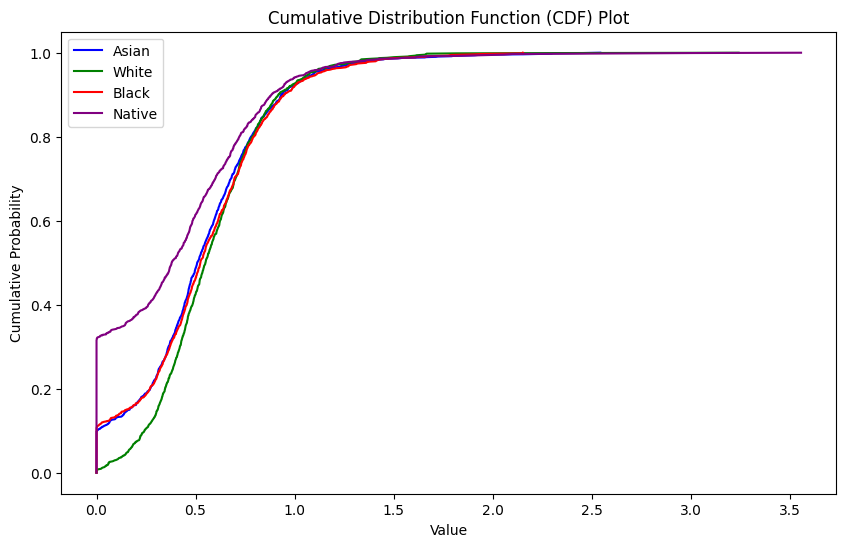

In [15]:
# CDF plot
race_variables = ['Asian', 'White', 'Black', 'Native']
colors = ['blue', 'green', 'red', 'purple']

fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables, colors):
    values = np.sort(data[var])
    cumulative = np.arange(1, len(values) + 1) / len(values)
    ax.plot(values, cumulative, label=var, color=color)

ax.set_title('Cumulative Distribution Function (CDF) Plot')
ax.set_xlabel('Value')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='upper left')

plt.show()

In [18]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix = pd.DataFrame(index=race_variables, columns=race_variables)

# Calculate the average difference for each pair of variables
for row_var in race_variables:
    for col_var in race_variables:
        if row_var != col_var:
            matrix.loc[row_var, col_var] = data[row_var].mean() - data[col_var].mean()

In [19]:
matrix

,Asian,White,Black,Native
Asian,NaN,-0.045684,-0.00798,0.12547
White,0.045684,NaN,0.037705,0.171154
Black,0.00798,-0.037705,NaN,0.133449
Native,-0.12547,-0.171154,-0.133449,NaN


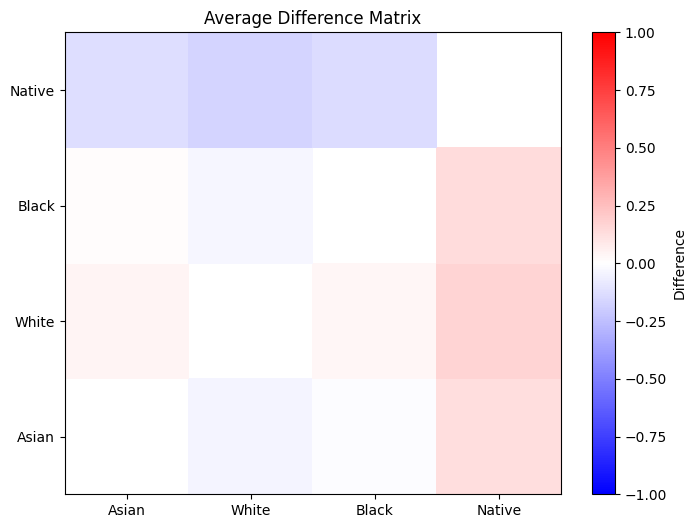

In [20]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix = matrix.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap('bwr')

plt.figure(figsize=(8, 6))
plt.pcolor(matrix, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label='Difference')
plt.xticks(np.arange(0.5, len(matrix.columns), 1), matrix.columns)
plt.yticks(np.arange(0.5, len(matrix.index), 1), matrix.index)
plt.title('Average Difference Matrix')
plt.show()

In [23]:
data.columns

Index(['Asian', 'White', 'Black', 'Native', 'state', 'county', 'tract',
       'Median Household Income', 'Educational Attainment',
       'Employment Status', 'Housing Tenure', 'Poverty Status'],
      dtype='object')

In [24]:
# Regression
#data['Asian Supply'] *= 1000

# Define the covariates, please replace with the actual ones you are using
covariates = ['Median Household Income', 'Educational Attainment', 'Employment Status', 'Housing Tenure', 'Poverty Status']

regression_results = []
extra_info = []

for i in range(len(covariates)):
    X = sm.add_constant(data[covariates[:i + 1]])
    y = data['Asian']

    model = sm.OLS(y, X)
    result = model.fit()

    rmse = sqrt(mean_squared_error(y, result.predict(X)))
    regression_results.append(result)
    extra_info.append({'N': int(result.nobs), 'R2': result.rsquared_adj, 'RMSE': rmse})

summary_table = summary_col(
    regression_results,
    stars=True,
    float_format='%.3f',
    model_names=[f'({i + 1})' for i in range(len(covariates))],
    info_dict={'N': lambda x: f"{x.nobs:.0f}",
               'R2': lambda x: f"{x.rsquared_adj:.3f}",
               'RMSE': lambda x: f"{sqrt(mean_squared_error(y, x.predict())):.3f}"}
)

In [26]:
summary_table

,(1),(2),(3),(4),(5)
Educational Attainment,,0.000***,0.000***,0.000***,0.000***
,,(0.000),(0.000),(0.000),(0.000)
Employment Status,,,-0.000***,0.000,0.000
,,,(0.000),(0.000),(0.000)
Housing Tenure,,,,-0.000***,-0.000***
,,,,(0.000),(0.000)
Median Household Income,-0.000,-0.000***,-0.000***,-0.000**,-0.000***
,(0.000),(0.000),(0.000),(0.000),(0.000)
Poverty Status,,,,,-0.000
,,,,,(0.000)


In [37]:
def run_regression_analysis(covariates, outcome_variable, data, scalar=1):
    regression_results = []
    extra_info = []

    for i in range(len(covariates)):
        X = sm.add_constant(data[covariates[:i + 1]])
        y = data[outcome_variable] * scalar

        model = sm.OLS(y, X)
        result = model.fit()

        rmse = sqrt(mean_squared_error(y, result.predict(X)))
        regression_results.append(result)
        extra_info.append({'N': int(result.nobs), 'R2': result.rsquared_adj, 'RMSE': rmse})

    return regression_results, extra_info


In [38]:
# Define the covariates
covariates = ['Median Household Income', 'Educational Attainment', 'Employment Status', 'Housing Tenure', 'Poverty Status']

# Define the outcome variable
outcome_variable = 'Asian'  # Replace with your desired outcome variable

# Define the scalar
scalar = 1000  # Replace with your desired scalar

# Call the function to run the regression analysis
regression_results, extra_info = run_regression_analysis(covariates, outcome_variable, data, scalar)

# Generate the summary table
summary_table = summary_col(
    regression_results,
    stars=True,
    float_format='%.3f',
    model_names=[f'({i + 1})' for i in range(len(covariates))],
    info_dict={'N': lambda x: f"{x.nobs:.0f}",
               'R2': lambda x: f"{x.rsquared_adj:.3f}",
               'RMSE': lambda x: f"{sqrt(mean_squared_error(y, x.predict())):.3f}"}
)

In [39]:
summary_table

,(1),(2),(3),(4),(5)
Educational Attainment,,0.142***,0.256***,0.242***,0.234***
,,(0.025),(0.041),(0.041),(0.041)
Employment Status,,,-0.051***,0.018,0.035
,,,(0.015),(0.020),(0.024)
Housing Tenure,,,,-0.158***,-0.177***
,,,,(0.029),(0.033)
Median Household Income,-0.000,-0.002***,-0.002***,-0.001**,-0.001***
,(0.000),(0.000),(0.000),(0.000),(0.001)
Poverty Status,,,,,-0.045
,,,,,(0.036)
